<a id='main' name="main"></a>
# Viral Data Analysis

Date: 2021.10.10

Author: © 2021 Mantas Arlauskas.

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

Here we analyze open COVID-19 data from [Our World in Data](https://ourworldindata.org/) to answer the following questions:

1. [Which 10 countries has the highest total number of people who received at least one vaccine dose per 100 people in the total population?](#Q1)
1. [How does the share of the population living in extreme poverty correlate with Covid mortality rate in different continents?](#Q2)
1. [Predict what will be the percentage of people vaccinated in Lithuania after next 30 days.](#Q3)

This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International license</a>. <a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons licencija" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a> 

## Load the data

In [29]:
# install statsmodels package
!pip install statsmodels

In [30]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.ar_model import ar_select_order
from sklearn.metrics import mean_squared_error

Download the data to cache locally. Do this once (a day), and comment out, not to DoS the server. (adopted from https://stackoverflow.com/a/35997720).

In [31]:
import requests
fname = 'owid-covid-data.csv'
url = 'https://covid.ourworldindata.org/data/' + fname
r = requests.get(url)
open(fname, 'wb').write(r.content)

33537167

Load the file to Pandas.

In [32]:
#url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
# download the file locally when developing, not to DoS the server:
url = "owid-covid-data.csv" 
df = pd.read_csv(url, parse_dates=[3])

Check the columns available.

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122379 entries, 0 to 122378
Data columns (total 65 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   iso_code                                 122379 non-null  object        
 1   continent                                116810 non-null  object        
 2   location                                 122379 non-null  object        
 3   date                                     122379 non-null  datetime64[ns]
 4   total_cases                              116124 non-null  float64       
 5   new_cases                                116120 non-null  float64       
 6   new_cases_smoothed                       115106 non-null  float64       
 7   total_deaths                             105293 non-null  float64       
 8   new_deaths                               105446 non-null  float64       
 9   new_deaths_smoothed       

The columns are explained [here](https://github.com/owid/covid-19-data/blob/master/public/data/owid-covid-codebook.csv).

In [34]:
df.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
count,1.161240e+05,116120.000000,115106.000000,1.052930e+05,105446.000000,115106.000000,115513.000000,115509.000000,114500.000000,104695.000000,...,84513.000000,83287.000000,54396.000000,98418.000000,116062.000000,108354.000000,4322.000000,4322.000000,4322.000000,4322.000000
mean,1.454556e+06,6455.572597,6477.611828,3.676693e+04,144.804545,132.061251,18013.583980,83.798493,83.831677,375.863109,...,10.591777,32.740049,50.735039,3.023182,73.259437,0.726449,28164.447617,8.037462,15.032927,693.873443
std,9.727910e+06,39298.448196,38905.459780,2.190308e+05,789.372914,739.213727,30564.061418,195.094758,164.220915,633.900178,...,10.504517,13.506522,31.752870,2.452657,7.539937,0.150209,82695.599668,15.932903,31.102516,1098.524489
min,1.000000e+00,-74347.000000,-6223.000000,1.000000e+00,-1918.000000,-232.143000,0.001000,-3125.829000,-272.971000,0.001000,...,0.100000,7.700000,1.188000,0.100000,53.280000,0.394000,-31959.400000,-27.350000,-95.920000,-1728.844404
25%,2.023000e+03,3.000000,9.286000,6.900000e+01,0.000000,0.000000,354.835000,0.281000,1.558000,10.367500,...,1.900000,21.600000,19.351000,1.300000,67.920000,0.602000,-265.500000,-1.437500,-1.427500,-58.952356
50%,2.111750e+04,93.000000,115.500000,6.080000e+02,2.000000,1.714000,2764.542000,10.733000,14.832000,69.648000,...,6.300000,31.400000,49.839000,2.400000,74.620000,0.744000,1266.100000,4.355000,5.670000,242.865156
75%,2.169360e+05,928.000000,981.000000,5.264000e+03,19.000000,15.857000,21906.109000,81.646000,91.165500,456.018000,...,19.300000,41.100000,82.502000,3.861000,78.740000,0.848000,17289.675000,12.907500,21.155000,1159.448112
max,2.375782e+08,905948.000000,826439.429000,4.847462e+06,17977.000000,14722.857000,219654.231000,8620.690000,3385.473000,5984.547000,...,44.000000,78.100000,100.000000,13.800000,86.750000,0.957000,693243.800000,106.830000,373.280000,6098.955872


Remove duplicate rows.

In [35]:
df.drop_duplicates(inplace = True)

[back to the top](#main)
<a id='Q1' name='Q1'></a>
## 1. Which 10 countries has the highest total number of people who received at least one vaccine dose per 100 people in the total population? 

Firstly, we group data by location and select only last row.

In [36]:
df_iso = df.groupby('iso_code').last()
df_iso[['continent', 'location', 'people_vaccinated_per_hundred']]

,continent,location,people_vaccinated_per_hundred
iso_code,,,
ABW,North America,Aruba,76.27
AFG,Asia,Afghanistan,2.08
AGO,Africa,Angola,6.27
AIA,North America,Anguilla,63.13
ALB,Europe,Albania,33.44
...,...,...,...
WSM,Oceania,Samoa,57.31
YEM,Asia,Yemen,1.01
ZAF,Africa,South Africa,22.16


Remove rows which does not have continent. It means that location is a continent and we don't need that.

In [37]:
df1 = df_iso[df_iso['continent'].notna()] 

Remove rows which does not have 'people vaccinated per hundred' data.

In [38]:
df1 = df1[df1['people_vaccinated_per_hundred'].notna()]

Sort data by 'people vaccinated per hundred' column values and select first 10 rows.

In [39]:
df1 = df1.sort_values('people_vaccinated_per_hundred', ascending = False);
df1 = df1.head(10);

Display data using horizontal chart diagram.

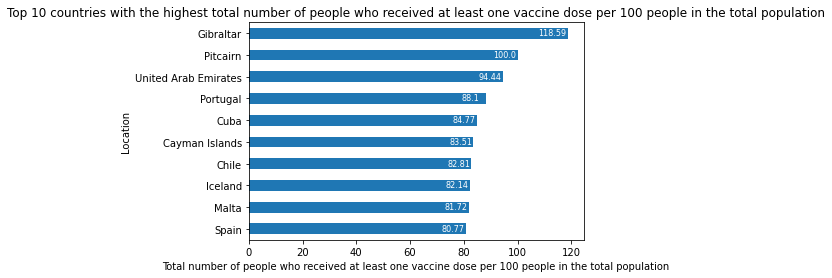

In [40]:
ax = df1.plot.barh(x='location', y='people_vaccinated_per_hundred', legend=0)
ax.set_title('Top 10 countries with the highest total number of people who received at least one vaccine dose per 100 people in the total population')
ax.set_ylabel('Location')
ax.set_xlabel('Total number of people who received at least one vaccine dose per 100 people in the total population')
ax.invert_yaxis()
for idx, val in enumerate(df1.people_vaccinated_per_hundred):
    ax.text(val - 11 if len(str(val)) == 6 else val - 9, idx + 0.1, val, fontsize=8, color='white')

From chart we can see that in Gibraltar the number of people who got at least one vaccine dose per 100 people is above 100. Let's take a look at Gibraltar population and the total number of people who received at least one dose of vaccine.

In [41]:
df1[['location', 'population', 'people_vaccinated']].head(1)

,location,population,people_vaccinated
iso_code,,,
GIB,Gibraltar,33691.0,39955.0


We can see that in Gibraltar the number of people who got at least one vaccine dose is bigger than the total number of people who live there.

[back to the top](#main)
<a id='Q2' name='Q2'></a>
## 2. How does the share of the population living in extreme poverty correlate with Covid mortality rate in different continents? 

Firstly, we select columns which are needed for this task.

In [42]:
df2 = df_iso[['total_deaths_per_million', 'extreme_poverty', 'location', 'continent']]
df2

,total_deaths_per_million,extreme_poverty,location,continent
iso_code,,,,
ABW,NaN,NaN,Aruba,North America
AFG,181.271,NaN,Afghanistan,Asia
AGO,47.681,NaN,Angola,Africa
AIA,NaN,NaN,Anguilla,North America
ALB,960.342,1.1,Albania,Europe
...,...,...,...,...
WSM,NaN,NaN,Samoa,Oceania
YEM,58.215,18.8,Yemen,Asia
ZAF,1470.504,18.9,South Africa,Africa


Then we remove rows which does not have some of the values.

In [43]:
df2 = df2.dropna();
df2

,total_deaths_per_million,extreme_poverty,location,continent
iso_code,,,,
ALB,960.342,1.1,Albania,Europe
ARG,2531.650,0.6,Argentina,South America
ARM,1862.790,1.8,Armenia,Asia
AUS,55.529,0.5,Australia,Oceania
AUT,1226.353,0.7,Austria,Europe
...,...,...,...,...
VUT,3.180,13.2,Vanuatu,Oceania
YEM,58.215,18.8,Yemen,Asia
ZAF,1470.504,18.9,South Africa,Africa


Now we display scatter plot diagrams for each continent with a linear regression model fit.

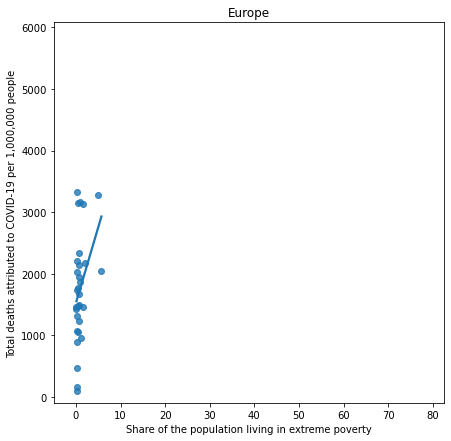

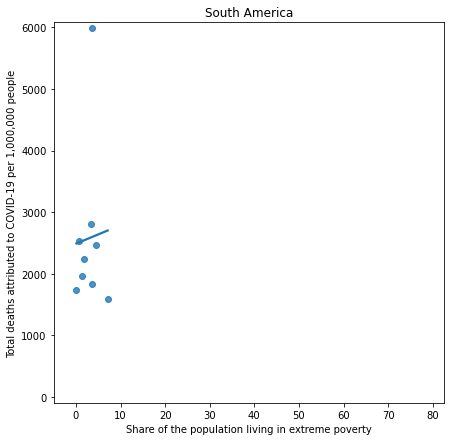

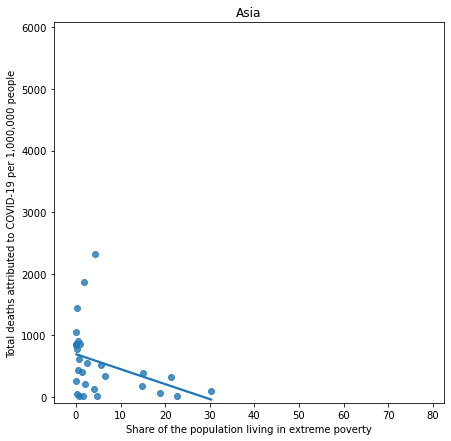

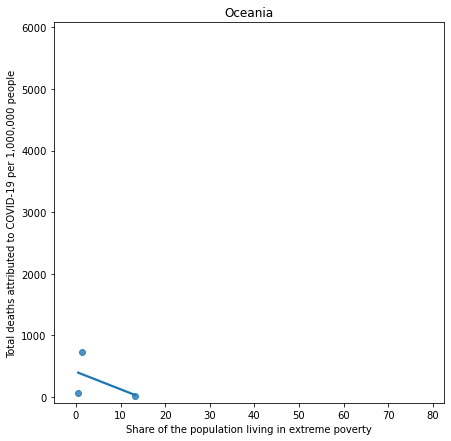

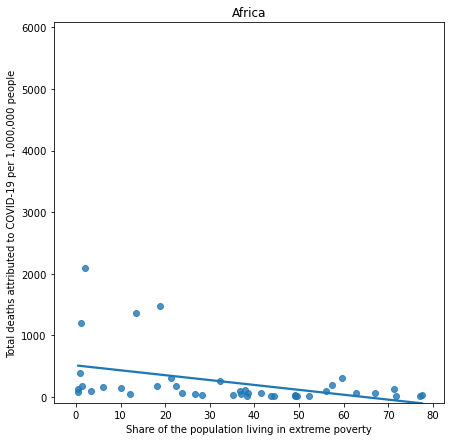

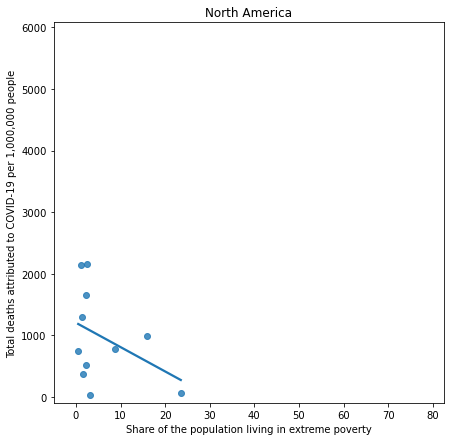

In [44]:
xmax = df2.extreme_poverty.max()
ymax = df2.total_deaths_per_million.max()
xspace = 5
yspace = 100

for continent in df2.continent.unique():
    continent_data = df2.loc[df2.continent == continent]
    plt.figure(figsize=(7,7))
    plt.ylim(-yspace, ymax + yspace)
    plt.xlim(-xspace, xmax + xspace)
    ax = sns.regplot(x=continent_data.extreme_poverty, y=continent_data.total_deaths_per_million, ci=None)
    ax.set(
        title=continent,
        xlabel='Share of the population living in extreme poverty',
        ylabel='Total deaths attributed to COVID-19 per 1,000,000 people'
    )

Calculate correlation coefficients and put them in data frame.

In [45]:
corr_values = []
corr_indexes = []
corr = df2.groupby('continent').corr().iloc[1::2, 0]
for tuple in corr.index.values:
    corr_indexes.append(tuple[0])
    corr_values.append(corr[tuple])
corr_data = pd.DataFrame({'correlation_coefficient': corr_values}, index=corr_indexes)
corr_data

,correlation_coefficient
Africa,-0.413584
Asia,-0.355013
Europe,0.367277
North America,-0.389473
Oceania,-0.501475
South America,0.049140


Display data using chart diagram.

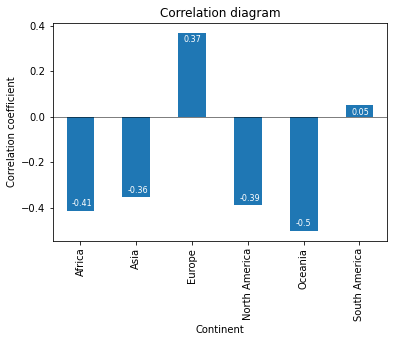

In [46]:
diagram = corr_data.plot.bar(legend=0)
diagram.axhline(y = 0, color = 'black', linewidth = 0.5)
diagram.set_ylabel('Correlation coefficient')
diagram.set_xlabel('Continent')
diagram.set_title('Correlation diagram')
for idx, val in enumerate(corr_data.iloc[:, 0]):
    diagram.text(idx - 0.15, val - 0.04 if val > 0 else val + 0.02, round(val, 2), fontsize=8, color='white')

From diagram we can see that correlation coefficient between the share of the population living in extreme poverty and Covid mortality rate is moderate or close to it (except for South America where there is no correlation). Interesting that in Europe correlation coefficient is positive which means you are more likely to die from Covid in poor country while in other continents this number is negative.

In [60]:
df2.corr().iloc[1::2, 0][0]

-0.4660364612314752

The number above shows correlation coefficient between the share of the population living in extreme poverty and Covid mortality rate in all continents combined. This number is negative which means people who live in poor countries are less likely to die from Covid.

[back to the top](#main)
<a id='Q3' name='Q3'></a>
## 3. Predict what will be the percentage of people vaccinated in Lithuania after next 30 days. 

First of all, select all rows where location is Lithuania and remove all rows where people fully vaccinated per 100 value is not defined.

In [48]:
df3 = df.loc[df['location'] == 'Lithuania']
df3 = df3[df3['people_fully_vaccinated_per_hundred'].notna()]
df3

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
65085,LTU,Europe,Lithuania,2021-01-17,170036.0,842.0,1185.000,2450.0,31.0,35.286,...,21.3,38.0,NaN,6.56,75.93,0.882,6727.1,16.84,42.18,2500.908969
65086,LTU,Europe,Lithuania,2021-01-18,170513.0,477.0,1142.571,2476.0,26.0,32.857,...,21.3,38.0,NaN,6.56,75.93,0.882,NaN,NaN,NaN,NaN
65087,LTU,Europe,Lithuania,2021-01-19,171380.0,867.0,1121.857,2498.0,22.0,31.143,...,21.3,38.0,NaN,6.56,75.93,0.882,NaN,NaN,NaN,NaN
65088,LTU,Europe,Lithuania,2021-01-20,172612.0,1232.0,1045.857,2523.0,25.0,29.429,...,21.3,38.0,NaN,6.56,75.93,0.882,NaN,NaN,NaN,NaN
65089,LTU,Europe,Lithuania,2021-01-21,173889.0,1277.0,1021.857,2561.0,38.0,30.143,...,21.3,38.0,NaN,6.56,75.93,0.882,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65346,LTU,Europe,Lithuania,2021-10-05,340080.0,1548.0,1740.571,5116.0,29.0,24.286,...,21.3,38.0,NaN,6.56,75.93,0.882,NaN,NaN,NaN,NaN
65347,LTU,Europe,Lithuania,2021-10-06,342827.0,2747.0,1851.143,5134.0,18.0,24.143,...,21.3,38.0,NaN,6.56,75.93,0.882,NaN,NaN,NaN,NaN
65348,LTU,Europe,Lithuania,2021-10-07,345095.0,2268.0,1916.000,5158.0,24.0,23.571,...,21.3,38.0,NaN,6.56,75.93,0.882,NaN,NaN,NaN,NaN
65349,LTU,Europe,Lithuania,2021-10-08,347548.0,2453.0,1979.714,5179.0,21.0,23.571,...,21.3,38.0,NaN,6.56,75.93,0.882,NaN,NaN,NaN,NaN


Select only relevant columns.

In [49]:
df3 = df3[['people_fully_vaccinated_per_hundred', 'date']]
df3

,people_fully_vaccinated_per_hundred,date
65085,0.04,2021-01-17
65086,0.10,2021-01-18
65087,0.25,2021-01-19
65088,0.32,2021-01-20
65089,0.34,2021-01-21
...,...,...
65346,60.47,2021-10-05
65347,60.56,2021-10-06
65348,60.65,2021-10-07
65349,60.75,2021-10-08


Set date as data set index and set period to day.

In [50]:
df3.set_index('date',inplace=True) 
df3.index = pd.DatetimeIndex(df3.index).to_period('D')
df3

,people_fully_vaccinated_per_hundred
date,
2021-01-17,0.04
2021-01-18,0.10
2021-01-19,0.25
2021-01-20,0.32
2021-01-21,0.34
...,...
2021-10-05,60.47
2021-10-06,60.56
2021-10-07,60.65


Split data into two data sets where one data set will be used for training and other for testing. Last 20 days will be used for testing.

In [51]:
days = 20
df3_train = df3.drop(df3.tail(days).index)
df3_test = df3.drop(df3.head(len(df3.index) - days).index)

We will use Autoregressive model where we forecast the output using the linear combination of past input values.

In [52]:
start = df3_test.index[0]
end = df3_test.index[len(df3_test.index)-1]
model = ar_select_order(df3_train, 15, old_names=False).model.fit()
prediction = model.predict(start, end)

Display results.

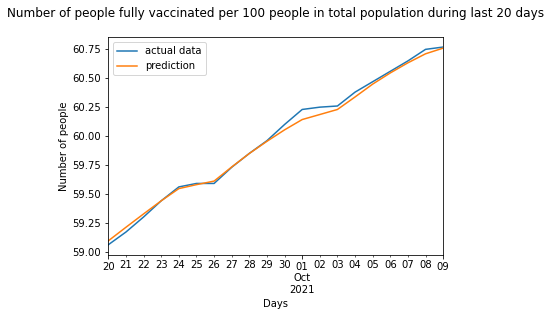

In [53]:
def plot_data(data, title, y_label, x_label, legend):
    diagram = data.plot()
    diagram.set_title(title, pad=20)
    diagram.set_ylabel(y_label)
    diagram.set_xlabel(x_label)
    diagram.legend(legend);

plot_data(
    pd.concat([df3_test, prediction], axis=1),
    'Number of people fully vaccinated per 100 people in total population during last 20 days',
    'Number of people',
    'Days',
    ["actual data", "prediction"]
)

From graph we can see that prediction curve looks quite similar to actual curve and it shows similar trends.

Let's calculate MSE.

In [54]:
mean_squared_error(df3_test, prediction)

0.0011616132015596764

MSE is close to zero which is good. It means that difference between prediction and actual data is small.

Then let's predict data for next 30 days.

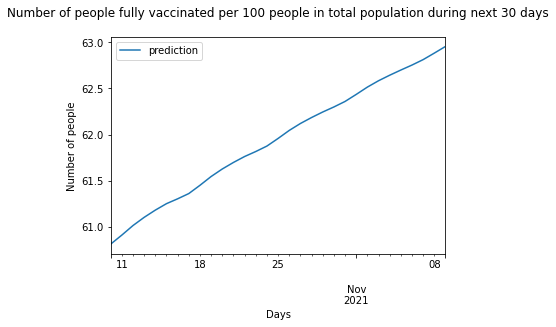

In [57]:
start = datetime.today()
end = start + timedelta(days=30)
prediction = model.predict(start, end)
plot_data(
    prediction,
    'Number of people fully vaccinated per 100 people in total population during next 30 days',
    'Number of people',
    'Days',
    ["prediction"]
)

In [58]:
pd.DataFrame(prediction, columns=['Number of people fully vaccinated per 100 people in total population']).tail(1)

,Number of people fully vaccinated per 100 people in total population
2021-11-09,62.955211


From the results we can say that percentage of people vaccinated in Lithuania after next 30 days should be similar to the number above.